# A data-driven PFC model

In [1]:
import brainpy as bp
import brainpy.math as bm
import numpy as np

from network_setup import setup_neuron_params, setup_synapse_params

In [2]:
bp.__version__

'2.4.3.post3'

Reimplementation of the paper:

- Hass, Joachim, Loreen Hertäg, and Daniel Durstewitz. "A detailed data-driven network model of prefrontal cortex reproduces key features of in vivo activity." PLoS computational biology 12.5 (2016): e1004930.

I run the reimplementation model using the GPU device. 

Instead of using the proposed ``SimpAdEx`` neuron model, here we simulate the network dynamics with the AdEx model.

Note that this model does not reproduce the firing partterns reported in the paper exactly. 

In [3]:
class AdExIF(bp.dyn.NeuDyn):
  def __init__(
      self, size, V_up=-40, delta=2., tau_ref=5., tau_w=500, a=4, b=20, C=150,
      gL=10, EL=-65, V_reset=-65, V_T=-30., name=None, method='exp_euler',
      V_initializer=None, w_initializer=bp.init.Constant(0.), Ib=None,
  ):
    super().__init__(size=size, name=name)

    self.Ib = Ib

    # neuronal parameters
    self.tau_ref = bp.init.parameter(tau_ref, self.varshape)
    self.V_up = bp.init.parameter(V_up, self.varshape)
    self.delta_T = bp.init.parameter(delta, self.varshape)
    self.tau_w = bp.init.parameter(tau_w, self.varshape)
    self.a = bp.init.parameter(a, self.varshape)
    self.b = bp.init.parameter(b, self.varshape)
    self.C = bp.init.parameter(C, self.varshape)
    self.g_L = bp.init.parameter(gL, self.varshape)
    self.E_L = bp.init.parameter(EL, self.varshape)
    self.V_r = bp.init.parameter(V_reset, self.varshape)
    self.V_T = bp.init.parameter(V_T, self.varshape)

    # neuronal variables
    if V_initializer is None:
      assert not callable(V_reset)
      V_initializer = bp.init.Constant(V_reset)
    self.V_initializer = V_initializer
    self.w_initializer = w_initializer

    # integral
    self.integral = bp.odeint(bp.JointEq(self.dV, self.dw), method=method)
    self.reset_state()

  def reset_state(self, *args, **kwargs):
    self.V = bp.init.variable_(self.V_initializer, self.varshape)
    self.w = bp.init.variable_(self.w_initializer, self.varshape)
    self.spike = bm.Variable(self.varshape, dtype=bool)
    self.t_last_spike = bm.Variable(bm.ones(self.varshape) * -1e8)

  def dV(self, V, t, w, Iext=None):
    I = 0. if Iext is None else Iext
    if self.Ib is not None:
      I = I + self.Ib
    dVdt = (self.g_L * self.delta_T * bm.exp((V - self.V_up) / self.delta_T)
            - w + self.g_L * (self.E_L - V) + I) / self.C
    return dVdt

  def dw(self, w, t, V):
    dwdt = (self.a * (V - self.E_L) - w) / self.tau_w
    return dwdt

  def update(self, x=None):
    t = bp.share.load('t')
    dt = bp.share.load('dt')
    V, w = self.integral(self.V.value, self.w.value, t, Iext=x, dt=dt)
    refractory = (t - self.t_last_spike) <= self.tau_ref
    V = bm.where(refractory, self.V.value, V)
    spike = V >= self.V_up
    self.V.value = bm.where(spike, self.V_r, V)
    self.w.value = bm.where(spike, w + self.b, w)
    self.spike.value = spike
    self.t_last_spike.value = bm.where(spike, t, self.t_last_spike)
    return self.spike.value

  def return_info(self):
    return self.spike


In [4]:
class STPLinear(bp.DynamicalSystem):
  def __init__(self, g_max, mask, U, tau_d, tau_f, failure_rate=0.3):
    super().__init__()
    # connection matrix
    self.mask = mask
    # weight matrix
    self.g_max = g_max
    # dropout
    self.dropout = bp.dnn.Dropout(1 - failure_rate)
    # stp
    self.stp = bp.dyn.STP(mask.shape, keep_size=True, U=U, tau_d=tau_d, tau_f=tau_f)

  def update(self, spike):
    spk = spike
    if spike.ndim == 1:
      spk = bm.expand_dims(spk, 1)
    stp = self.stp(spk)
    x = bm.ones(spike.shape)
    return x @ self.dropout(stp * self.g_max * self.mask, fit=True)

In [5]:
class MgBlock(bp.dyn.SynOut):
  def __init__(self, E=0., a=1.09, b=0.19, c=0.064):
    super().__init__()
    self.E, self.a, self.b, self.c = E, a, b, c

  def update(self, conductance, potential):
    return conductance * (self.E - potential) * self.a / (1 + self.b / bm.exp(-self.c * potential))


In [6]:
class AdExNet(bp.DynamicalSystem):
  def __init__(self, num_per_column: int, num_column: int):
    super().__init__()

    self.num_column = num_column
    self.num_per_column = num_per_column

    # ---------- Scales ---------- #
    print('Initializing neuron parameters ...')
    neu_pars, neu_init, group_dist = setup_neuron_params(num_per_column, num_column)
    self.group_dist = group_dist
    num = neu_pars.shape[1]
    Ib = self.generate_bg_input(num)

    print('Initializing synapse parameters ...')
    gmax_scale = [1, 1, 1, 1]
    pCon_scale = [1, 1, 1, 1]
    param_std_scale = np.ones((10, 14))  # Scale of std of membrane parameters for each group
    res = setup_synapse_params(
      num_per_column, num_column, group_dist,
      scales=(gmax_scale, pCon_scale, param_std_scale),
      clustering=True
    )
    self.res = res

    print('Initializing neuron groups ...')
    self.group = AdExIF(num, Ib=Ib)

    # below is to set neuron parameters
    self.group.C = bm.asarray(neu_pars[0])
    self.group.g_L = bm.asarray(neu_pars[1])
    self.group.E_L = bm.asarray(neu_pars[2])
    self.group.delta_T = bm.asarray(neu_pars[3])
    self.group.V_up = bm.asarray(neu_pars[4])
    self.group.tau_w = bm.asarray(neu_pars[5])
    self.group.a = bm.asarray(neu_pars[6])
    self.group.b = bm.asarray(neu_pars[7])
    self.group.V_r = bm.asarray(neu_pars[8])
    self.group.V_T = bm.asarray(neu_pars[9])

    # neuron initial variables
    self.group.V = bm.asarray(neu_init[0])
    self.group.w = bm.asarray(neu_init[1])

    # delay
    self.delay = bp.VarDelay(self.group.spike)
    self.delay.register_entry('delay', 1.)

    print('Initializing synaptic projections ...')
    # AMPA
    self.ampa = bp.dyn.ProjAlignPost1(
      comm=STPLinear(bm.asarray(res['ampa_g_max']),
                     bm.asarray(res['exe_conn']),
                     bm.asarray(res['ampa_U']),
                     bm.asarray(res['ampa_tau_d']),
                     bm.asarray(res['ampa_tau_f'])),
      syn=bp.dyn.DualExponV2(num, tau_decay=10., tau_rise=1.4),
      out=bp.dyn.COBA(E=0.),
      post=self.group,
    )

    # GABA
    self.gaba = bp.dyn.ProjAlignPost1(
      comm=STPLinear(bm.asarray(res['gaba_g_max']),
                     bm.asarray(res['inh_conn']),
                     bm.asarray(res['gaba_U']),
                     bm.asarray(res['gaba_tau_d']),
                     bm.asarray(res['gaba_tau_f'])),
      syn=bp.dyn.DualExponV2(num, tau_decay=40., tau_rise=3.0),
      out=bp.dyn.COBA(E=-70.),
      post=self.group,
    )

    # NMDA
    self.nmda = bp.dyn.ProjAlignPost1(
      comm=STPLinear(bm.asarray(res['nmda_g_max']),
                     bm.asarray(res['exe_conn']),
                     bm.asarray(res['nmda_U']),
                     bm.asarray(res['nmda_tau_d']),
                     bm.asarray(res['nmda_tau_f'])),
      syn=bp.dyn.DualExponV2(num, tau_decay=75, tau_rise=4.3),
      out=MgBlock(E=0., a=1.09, b=0.19, c=0.064),
      post=self.group,
    )

  def update(self, inp=0.):
    sps = self.delay.at('delay')
    exe_sps = sps[self.res['exe_indices']]
    inh_sps = sps[self.res['inh_indices']]

    # update projections first
    self.ampa(exe_sps)
    self.gaba(inh_sps)
    self.nmda(exe_sps)

    # update neurons
    self.delay(self.group(inp))

    # return for monitoring
    return self.group.spike.value

  def generate_bg_input(self, num, Iexc=250., Iinh=200.):
    constant_current = [[Iexc, Iinh, Iinh, Iinh, Iinh, Iinh, Iinh, Iexc, Iinh, Iinh, Iinh, Iinh, Iinh, Iinh]
                        for _ in range(self.num_column)]
    I_DC = np.arange(num)
    if len(constant_current):
      for i_col in range(len(self.group_dist[0])):
        for j_group in range(len(self.group_dist)):
          indices = np.asarray(self.group_dist[j_group][i_col]).astype(int)
          I_DC[indices] = constant_current[i_col][j_group]
    return I_DC

In [7]:
net = AdExNet(1000, num_column=1)

indices = np.arange(int(2000. / bm.get_dt()))
spks = bm.for_loop(net.step_run, indices)

Initializing neuron parameters ...



/mnt/d/codes/githubs/computational_neuroscience_reps/ReScience_Hass_Hertag_Durstewitz_2016/brainpy_reproduce/network_setup.py:349: RuntimeWarning: invalid value encountered in log
  t_lat_LIF_act[j_typ] = C * np.log(I / (I + gL * (EL - Vth / 2))) / gL
/mnt/d/codes/githubs/computational_neuroscience_reps/ReScience_Hass_Hertag_Durstewitz_2016/brainpy_reproduce/network_setup.py:975: RuntimeWarning: invalid value encountered in power
  X_inv = (mean_X + std_decr * std_X * X_trans) ** (1 / k)


REPORT: Neuronal parameters generated

Initializing synapse parameters ...
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 22
         Function evaluations: 44
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 22
         Function evaluations: 44
REPORT: Synaptic connectivity and parameters generated

Initializing neuron groups ...
Initializing synaptic projections ...


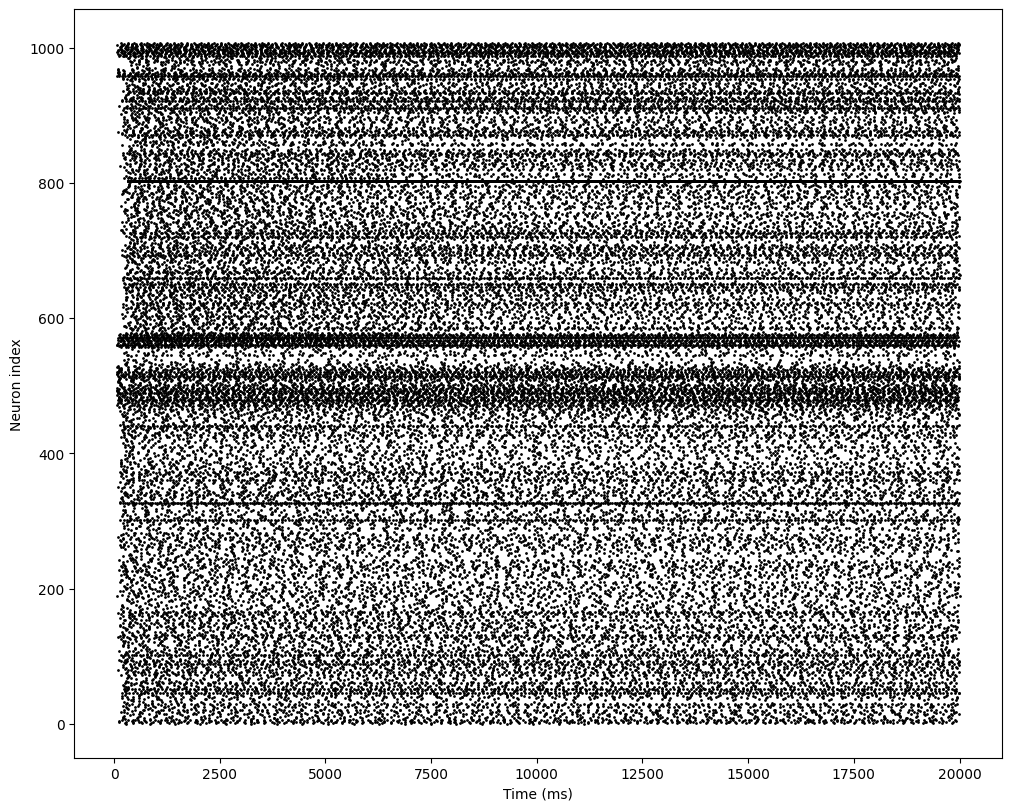

In [9]:
fig, gs = bp.visualize.get_figure(1, 1, 8, 10)
ax = fig.add_subplot(gs[0, 0])
bp.visualize.raster_plot(indices, spks, show=True)